# Camera Calibration

In [ ]:
# # # UNIX-based system
# base_path = "d:\\VIBOT Master\\Semester 2\\Computer Vision\\Practicals\\Stereo\\stereo_reconstruction_cv"

# LINUX-based system
base_path = "/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv"
dataset_name = "dataset/d3"
calib_data_name = "calibration_data_logitech_1280x720"
# calib_data_name = "calibration_data_logitech_3840x2160"

lowe_ratio = 1  # for filtering feature matches

%cd $base_path

/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv


In [4]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import open3d as o3d


class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            100,
            1e-5,
        )

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9 * 7, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        checkerboardsize = (9, 7)
        images = glob.glob(cal_path + "/*.jpg")
        images_right = sorted([os.path.join(cal_path, img_path) for img_path in images])
        images_left = sorted([os.path.join(cal_path, img_path) for img_path in images])

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(
                gray_l,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )
            ret_r, corners_r = cv2.findChessboardCorners(
                gray_r,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )

            # If found, add object points, image points (after refining them)
            # self.objpoints.append(self.objp)

            if ret_l and ret_r:
                rt = cv2.cornerSubPix(
                    gray_l, corners_l, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(
                    img_l, checkerboardsize, corners_l, ret_l
                )
                rt = cv2.cornerSubPix(
                    gray_r, corners_r, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(
                    img_r, checkerboardsize, corners_r, ret_r
                )
                self.objpoints.append(self.objp)

        img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None
        )
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None
        )

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST

        stereocalib_criteria = (
            cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            100,
            1e-5,
        )
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints,
            self.imgpoints_l,
            self.imgpoints_r,
            self.M1,
            self.d1,
            self.M2,
            self.d2,
            dims,
            criteria=stereocalib_criteria,
            flags=flags,
        )

        print("Intrinsic_mtx_1", M1)
        print("dist_1", d1)
        print("Intrinsic_mtx_2", M2)
        print("dist_2", d2)
        print("R", R)
        print("T", T)
        print("E", E)
        print("F", F)
        camera_model = dict(
            [
                ("M1", M1),
                ("M2", M2),
                ("dist1", d1),
                ("dist2", d2),
                ("rvecs1", self.r1),
                ("rvecs2", self.r2),
                ("R", R),
                ("T", T),
                ("E", E),
                ("F", F),
                ("image_size", dims),
            ]
        )

        return camera_model

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
cal_data = StereoCalibration(os.path.join(base_path, calib_data_name))

K0 = np.array(cal_data.camera_model["M1"])
K1 = np.array(cal_data.camera_model["M1"])
dist_coeffs0 = np.array(cal_data.camera_model["dist1"])
dist_coeffs1 = np.array(cal_data.camera_model["dist2"])
R = np.array(cal_data.camera_model["R"])
T = np.array(cal_data.camera_model["T"])
F = np.array(cal_data.camera_model["F"])
E = np.array(cal_data.camera_model["E"])
image_size = np.array(cal_data.camera_model["image_size"])

Intrinsic_mtx_1 [[2.25370759e+03 0.00000000e+00 1.92969309e+03]
 [0.00000000e+00 2.24471892e+03 1.05763445e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_1 [[ 2.08993190e-01 -5.57647266e-01 -7.19877887e-06  5.16897145e-04
   3.81154053e-01]]
Intrinsic_mtx_2 [[2.25370759e+03 0.00000000e+00 1.92969309e+03]
 [0.00000000e+00 2.24471892e+03 1.05763445e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_2 [[ 2.08993190e-01 -5.57647266e-01 -7.19877887e-06  5.16897145e-04
   3.81154053e-01]]
R [[ 1.00000000e+00  8.42397398e-13 -1.58471107e-12]
 [-8.42397398e-13  1.00000000e+00 -4.56223868e-13]
 [ 1.58471107e-12  4.56223868e-13  1.00000000e+00]]
T [[ 2.32424546e-11]
 [ 1.14559823e-11]
 [-9.74192479e-12]]
E [[ 9.94784987e-24  9.74192479e-12  1.14559823e-11]
 [-9.74192479e-12 -1.88103346e-23 -2.32424546e-11]
 [-1.14559823e-11  2.32424546e-11  7.55065943e-24]]
F [[ 1.24264937e-07  1.22179897e+05  1.93292861e+08]
 [-1.22179897e+05 -2.36857480e-07 -4.21183661e+08]
 [-1.93292861e+0

# Rectification

In [6]:
def stereo_rectify(K0, K1, R, T, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0, K1), rotation (R),
    translation (T) between the two cameras, and the image size, and returns
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R: Rotation matrix between the two cameras (3x3 numpy array).
        T: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T = T.astype(np.float64)  # Ensure T is float64 for cv2.stereoRectify

    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        K0, None, K1, None, image_size, R, T, alpha=1, flags=cv2.CALIB_CB_ACCURACY
    )
    return R1, R2, P1, P2, Q

In [7]:
# Perform stereo rectification
R1, R2, P1, P2, Q = stereo_rectify(K0, K1, R, T, image_size)

# Print results for verification
print("R1:\n", R1)
print("R2:\n", R2)
print("P1:\n", P1)
print("P2:\n", P2)
print("Q:\n", Q)

R1:
 [[ 0.83958876  0.41382523 -0.35190821]
 [-0.41382523  0.90690783  0.07916361]
 [ 0.35190821  0.07916361  0.93268094]]
R2:
 [[ 0.83958876  0.41382523 -0.35190821]
 [-0.41382523  0.90690783  0.07916361]
 [ 0.35190821  0.07916361  0.93268094]]
P1:
 [[7.29402108e+02 0.00000000e+00 3.51589533e+03 0.00000000e+00]
 [0.00000000e+00 7.29402108e+02 5.89922386e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
P2:
 [[7.29402108e+02 0.00000000e+00 3.51589533e+03 2.01921418e-08]
 [0.00000000e+00 7.29402108e+02 5.89922386e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -3.51589533e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.89922386e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.29402108e+02]
 [ 0.00000000e+00  0.00000000e+00 -3.61230679e+10  0.00000000e+00]]


In [8]:
# Example usage (replace with your actual paths)
left_image = os.path.join(dataset_name, "img1.jpg")
right_image = os.path.join(dataset_name, "img2.jpg")

# Read Images
imgL = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image)  # For color visualization
imgR_color = cv2.imread(right_image)  # For color visualization

# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32F)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32F)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

In [17]:
def draw_epilines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Text(0.5, 1.0, 'Disparity Map (SGBM)')

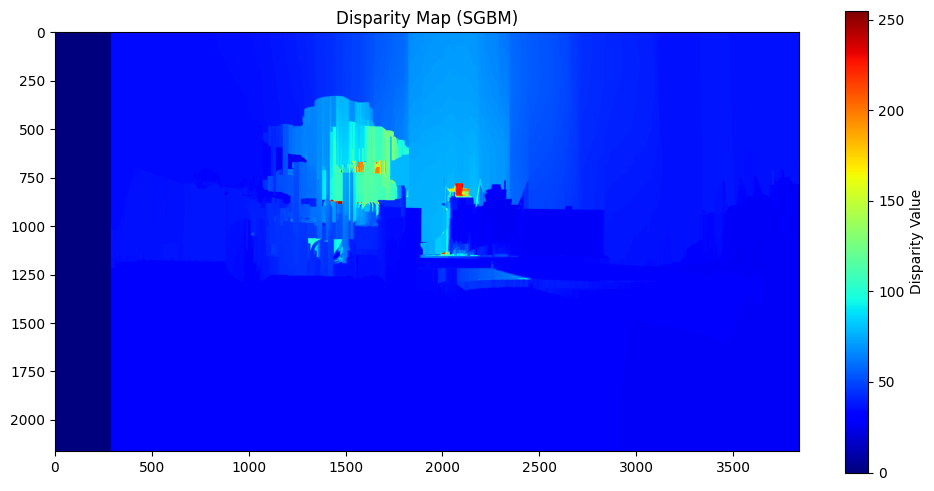

In [18]:
!pip3 install opencv-contrib-python
def compute_disparity_sgbm():
    """
    Computes the disparity map using Semi-Global Block Matching (SGBM).
    :param imgL: Left stereo image (grayscale)
    :param imgR: Right stereo image (grayscale)
    :return: Computed disparity map (normalized)
    """
    numdisparities = ((270 // 16) + 1) * 16  # Ensure numDisparities is a multiple of 16

    # Create a StereoSGBM object with tuned parameters
    stereo = cv2.StereoSGBM_create(
        minDisparity=16,  # Minimum possible disparity
        numDisparities=numdisparities,  # Maximum disparity range (must be multiple of 16)
        blockSize=13,  # Size of block matching window
        P1=8 * 3 * 10**2,  # Penalty for small disparity changes
        P2=32 * 3 * 10**2,  # Penalty for large disparity changes
        disp12MaxDiff=1,  # Max allowed difference in left-right disparity check
        uniquenessRatio=15,  # Ensures unique disparity values
        speckleWindowSize=200,  # Reduces noise in disparity map
        speckleRange=2,  # Limits disparity variation in small areas.
        preFilterCap=31    )

    return stereo


stereo_left = compute_disparity_sgbm()  # Compute SGBM disparity map


stereo_right = cv2.ximgproc.createRightMatcher(stereo_left)  # Right matcher for WLS

# Compute disparity maps
disparity_left = stereo_left.compute(imgL, imgR).astype(np.float32) / 16.0
disparity_right = stereo_right.compute(imgR, imgL).astype(np.float32) / 16.0

# Create WLS filter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo_left)
wls_filter.setLambda(1000000)# Higher values smooth more
wls_filter.setSigmaColor(3)  # Edge-preserving filter

# Apply WLS filtering
filtered_disparity = wls_filter.filter(
    disparity_left, imgL, disparity_map_right=disparity_right
)

# Normalize disparity for visualization
filtered_disparity_norm = cv2.normalize(
    filtered_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
)
filtered_disparity_norm = np.int16(filtered_disparity_norm)

# Display the computed disparity maps
plt.figure(figsize=(12, 6))  # Set figure size
# Plot SGBM disparity map
plt.subplot(1, 1, 1)
plt.imshow(filtered_disparity_norm, cmap="jet")  # Use plasma colormap for visualization
plt.colorbar(label="Disparity Value")  # Add color legend
plt.title("Disparity Map (SGBM)")  # Title for SGBM disparity map

In [19]:
def reconstruct_3D(disparity_map, Q):
    """
    Reconstructs a 3D point cloud from the disparity map using the reprojection matrix.

    :param disparity_map: The computed disparity map (output from StereoSGBM or StereoBM)
    :param Q: The reprojection matrix obtained from stereo rectification
    :return: A 3D point cloud where each pixel (x, y) has a corresponding 3D coordinate (X, Y, Z)
    """
    # Convert disparity map into a 3D point cloud
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    return points_3D

# Example usage (assuming Q is already computed from stereo rectification)
# Placeholder for reprojection matrix; replace with actual Q from stereo rectification

# Reconstruct 3D points using the SGBM disparity map
points_3D_sgbm = reconstruct_3D(filtered_disparity_norm, Q)
print(points_3D_sgbm)  # Print raw 3D point cloud data

# Print the shape of the generated 3D point clouds for verification
print("3D Points (SGBM):", points_3D_sgbm.shape)  # Shape should match input image size

[[[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [-2.4692184e-10  4.5363624e-10 -5.6089283e-10]
  [-2.4769081e-10  4.5363624e-10 -5.6089283e-10]
  [-2.4845978e-10  4.5363624e-10 -5.6089283e-10]]

 [[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [-2.4692184e-10  4.5286724e-10 -5.6089283e-10]
  [-2.4769081e-10  4.5286724e-10 -5.6089283e-10]
  [-2.4845978e-10  4.5286724e-10 -5.6089283e-10]]

 [[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [-2.4692184e-10  4.5209828e-10 -5.6089283e-10]
  [-2.4769081e-10  4.5209828e-10 -5.6089283e-10]
  [-2.4845978e-10  4.5209828e-10 -5.6089283e-10]]

 ...

 [[          -inf            inf            inf]
  [          -inf            inf       

In [20]:
import open3d as o3d


def visualize_point_cloud(points_3D, colors, disparity_map):
    """
    Visualizes the 3D point cloud using Open3D.

    :param points_3D: 3D reconstructed points (X, Y, Z) from disparity map
    :param colors: Corresponding RGB colors for each point
    :param disparity_map: Disparity map used for filtering valid points
    """
    # Mask invalid points (where disparity is NaN, infinite, or non-positive)
    mask = (
        ~np.isnan(points_3D[:, :, 0])
        & ~np.isinf(points_3D[:, :, 0])
        & (disparity_map > 0)
    )  # Added disparity threshold

    # Extract valid points and corresponding colors
    valid_points = points_3D[mask]
    valid_colors = colors[mask]

    # Create Open3D point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(
        valid_points.reshape(-1, 3)
    )  # Reshape into Nx3 format
    point_cloud.colors = o3d.utility.Vector3dVector(
        valid_colors.reshape(-1, 3) / 255.0
    )  # Normalize colors (0 to 1)

    # Visualize point cloud using Open3D
    o3d.visualization.draw_geometries([point_cloud])


# Load color image for point cloud visualization
colors = cv2.imread(left_image)  # Read color image
colors = cv2.cvtColor(
    colors, cv2.COLOR_BGR2RGB
)  # Convert from BGR (OpenCV format) to RGB

# Visualize the reconstructed point cloud using SGBM disparity map
visualize_point_cloud(points_3D_sgbm, colors, filtered_disparity_norm)

[[   3  579]
 [   4 1345]
 [   6 1341]
 ...
 [3832 1333]
 [3836  846]
 [3837 1316]]


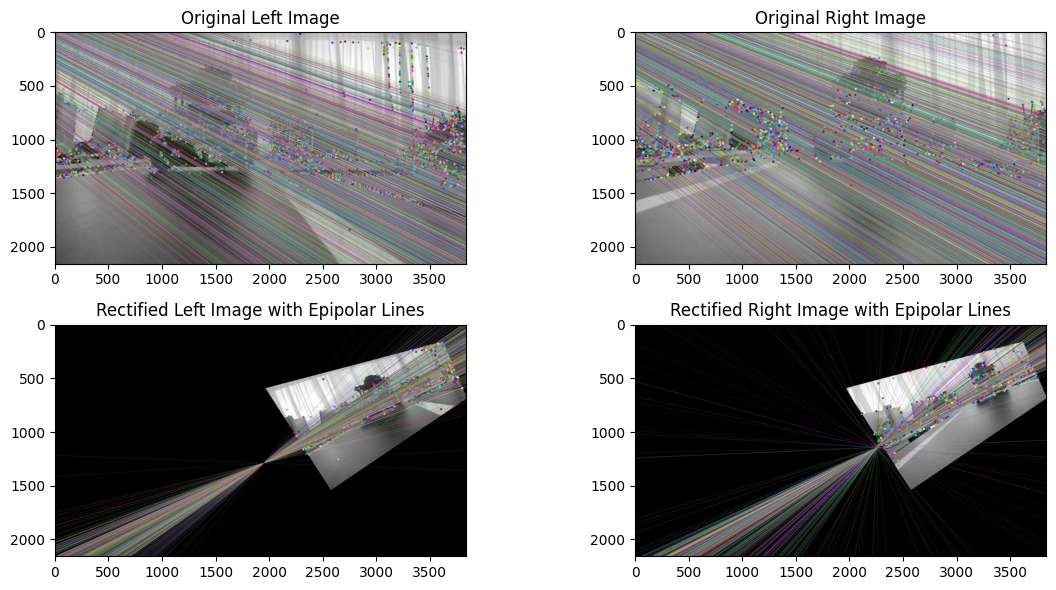

True

In [21]:
# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

# Filter matches using the Lowe's ratio test
pts_left = []
pts_right = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < lowe_ratio * n.distance:
        pts_left.append(keypoints_left[m.queryIdx].pt)
        pts_right.append(keypoints_right[m.trainIdx].pt)

pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)
print(pts_left)
left_before_lines = cv2.computeCorrespondEpilines(pts_right.reshape(-1, 1, 2), 2, F)
left_before_lines = left_before_lines.reshape(-1, 3)
imgL_before_rec, _ = draw_epilines(imgL, imgR, left_before_lines, pts_left, pts_right)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_before_lines = cv2.computeCorrespondEpilines(pts_left.reshape(-1, 1, 2), 1, F)
right_before_lines = right_before_lines.reshape(-1, 3)
imgR_before_rec, _ = draw_epilines(imgR, imgL, right_before_lines, pts_right, pts_left)
keypoints_left_rect, descriptors_left_rect = sift.detectAndCompute(imgL_rect, None)
keypoints_right_rect, descriptors_right_rect = sift.detectAndCompute(imgR_rect, None)

matches_rect = flann.knnMatch(descriptors_left_rect, descriptors_right_rect, k=2)

# Filter matches_rect using the Lowe's ratio test
pts_left_rect = []
pts_right_rect = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches_rect):
    if m.distance < lowe_ratio * n.distance:
        pts_left_rect.append(keypoints_left_rect[m.queryIdx].pt)
        pts_right_rect.append(keypoints_right_rect[m.trainIdx].pt)

pts_left_rect = np.int32(pts_left_rect)
pts_right_rect = np.int32(pts_right_rect)
F_rect, mask = cv2.findFundamentalMat(pts_left_rect, pts_right_rect, cv2.FM_LMEDS)

# We select only inlier points
pts_left_rect = pts_left_rect[mask.ravel() == 1]
pts_right_rect = pts_right_rect[mask.ravel() == 1]

# Draw epipolar lines on the rectified images

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_after_lines = cv2.computeCorrespondEpilines(
    pts_right_rect.reshape(-1, 1, 2), 2, F_rect
)
left_after_lines = left_after_lines.reshape(-1, 3)
imgL_after_rec, _ = draw_epilines(
    imgL_rect, imgR_rect, left_after_lines, pts_left_rect, pts_right_rect
)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_after_lines = cv2.computeCorrespondEpilines(
    pts_right_rect.reshape(-1, 1, 2), 1, F_rect
)
right_after_lines = right_after_lines.reshape(-1, 3)
imgR_after_rec, _ = draw_epilines(
    imgR_rect, imgL_rect, right_after_lines, pts_right_rect, pts_left_rect
)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_before_rec, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_before_rec, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(imgL_after_rec, cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(imgR_after_rec, cmap="gray")

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite(os.path.join(dataset_name, "left_rectified.jpg"), imgL_rect)
cv2.imwrite(os.path.join(dataset_name, "right_rectified.jpg"), imgR_rect)
cv2.imwrite("right_rectified_lines.jpg", imgR_after_rec)
cv2.imwrite("left_rectified_lines.jpg", imgL_after_rec)

In [22]:
R1, R2, P1, P2, Q

(array([[ 0.83958876,  0.41382523, -0.35190821],
        [-0.41382523,  0.90690783,  0.07916361],
        [ 0.35190821,  0.07916361,  0.93268094]]),
 array([[ 0.83958876,  0.41382523, -0.35190821],
        [-0.41382523,  0.90690783,  0.07916361],
        [ 0.35190821,  0.07916361,  0.93268094]]),
 array([[7.29402108e+02, 0.00000000e+00, 3.51589533e+03, 0.00000000e+00],
        [0.00000000e+00, 7.29402108e+02, 5.89922386e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[7.29402108e+02, 0.00000000e+00, 3.51589533e+03, 2.01921418e-08],
        [0.00000000e+00, 7.29402108e+02, 5.89922386e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -3.51589533e+03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -5.89922386e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          7.29402108

# Feature Detection and Matching with SIFT

In [23]:
def feat_detect_match(stereo_path, contrast_threshold=0.04):
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold)

    left_image = glob.glob(f"{stereo_path}/img1.jpg")
    right_image = glob.glob(f"{stereo_path}/img2.jpg")

    if not left_image or not right_image:
        return "Error: Missing img1.jpg or img2.jpg in the folder."

    imgL = cv2.imread(left_image[0], cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_image[0], cv2.IMREAD_GRAYSCALE)

    if imgL is None or imgR is None:
        return "Error: Failed to load one or both images."

    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
    print(f"SIFT: {len(keypoints_left)} keypoints detected in left image.")
    print(f"SIFT: {len(keypoints_right)} keypoints detected in right image.")

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]
    print(
        f"FLANN Matcher: {len(matches)} matches found, {len(good_matches)} after ratio test."
    )

    imgL_with_kp = cv2.drawKeypoints(
        imgL, keypoints_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    imgR_with_kp = cv2.drawKeypoints(
        imgR, keypoints_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    img_matches = cv2.drawMatchesKnn(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    img_good_matches = cv2.drawMatches(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    # extract points
    pts1 = []
    pts2 = []
    for i, (m) in enumerate(good_matches):
        pts2.append(keypoints_right[m.trainIdx].pt)
        pts1.append(keypoints_left[m.queryIdx].pt)
    pts1 = np.asarray(pts1)
    pts2 = np.asarray(pts2)

    return imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2

SIFT: 6774 keypoints detected in left image.
SIFT: 6107 keypoints detected in right image.
FLANN Matcher: 6774 matches found, 6773 after ratio test.


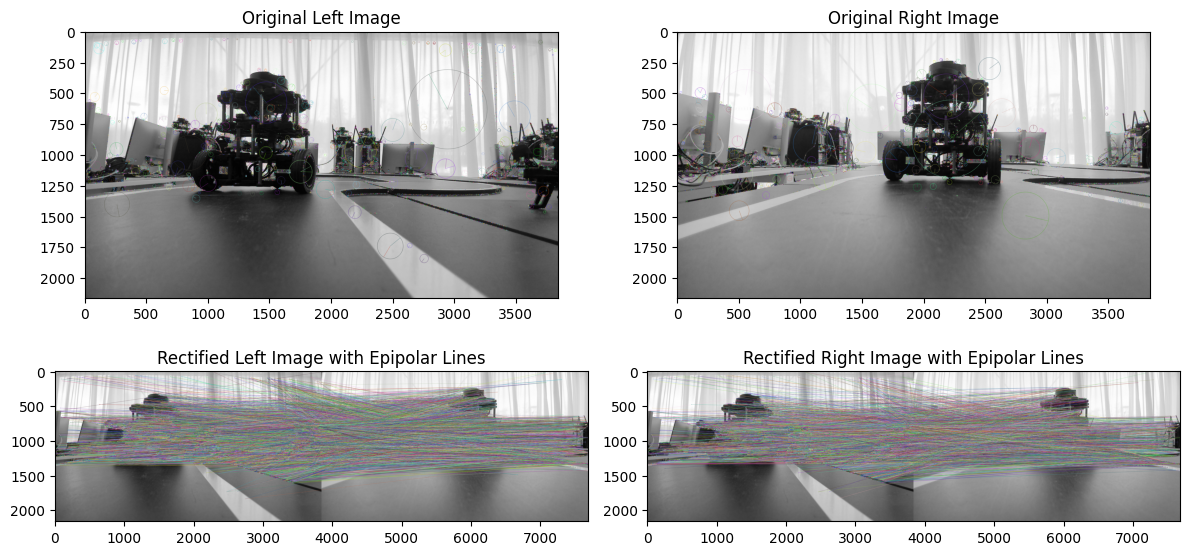

[[3.33362556e+00 5.79134033e+02]
 [4.61427784e+00 1.34512292e+03]
 [6.38900661e+00 1.34188574e+03]
 ...
 [3.83295459e+03 1.33350269e+03]
 [3.83643066e+03 8.46100830e+02]
 [3.83717505e+03 1.31629675e+03]]


In [24]:
imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2 = feat_detect_match(dataset_name)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_with_kp)

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_with_kp)

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(img_matches)

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(img_good_matches)

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite(os.path.join(dataset_name,"imgL_with_kp.jpg"), imgL_with_kp)
cv2.imwrite(os.path.join(dataset_name,"imgR_with_kp.jpg"), imgR_with_kp)
cv2.imwrite(os.path.join(dataset_name,"img_matches.jpg"), img_matches)
cv2.imwrite(os.path.join(dataset_name,"img_good_matches.jpg"), img_good_matches)
print(pts1)

## Triangulation (Sparse Reconstruction)

In [25]:
# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack(
    (R, T)
)  # Projection matrix for the second camera

print(points2_h)

# Perform triangulation to get 3D points
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

[[1.60977497e+01 1.07442389e+01 1.00000000e+00]
 [3.83454126e+03 1.33198291e+03 1.00000000e+00]
 [3.37334668e+03 1.26118982e+03 1.00000000e+00]
 ...
 [1.85465283e+03 1.15700281e+03 1.00000000e+00]
 [2.32103638e+03 5.77999084e+02 1.00000000e+00]
 [3.83454126e+03 1.33198291e+03 1.00000000e+00]]


In [26]:
def visualize_sparse_point_cloud(points_3D):
    """
    Visualize the 3D point cloud using Open3D.

    Parameters:
    - points_3D: 3D points to visualize.
    """
    try:
        # Create a point cloud object
        pcd = o3d.geometry.PointCloud()

        # Set the points
        pcd.points = o3d.utility.Vector3dVector(
            points_3D.T
        )  # Transpose to match Open3D format

        # Optionally, set colors (here we set all points to red)
        colors = np.array([[1, 0, 0] for _ in range(points_3D.shape[1])])  # Red color
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Visualize the point cloud
        o3d.visualization.draw_geometries(
            [pcd], window_name="3D Point Cloud", width=800, height=600
        )
    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")

In [27]:
visualize_sparse_point_cloud(points_3d)

In [28]:
# #Optional: Save the point cloud
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_3d.reshape(-1, 3))
# o3d.io.write_point_cloud(os.path.join(dataset_name,"point_cloud.ply"), pcd)

In [31]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# rectified_img1 = cv2.imread(os.path.join(dataset_name,"left_rectified.jpg"))
# rectified_img2 = cv2.imread(os.path.join(dataset_name,"right_rectified.jpg"))

# # Feature Detection and Matching using SIFT

# # surf = cv2.SURF_create()  # Updated SURF implementation
# # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# akaze = cv2.AKAZE_create()
# bf_akaze = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # sift = cv2.SIFT_create()
# # flann = cv2.FlannBasedMatcher()

# # orb = cv2.ORB_create()
# # bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Detect keypoints and descriptors in both images
# kp1, des1 = akaze.detectAndCompute(rectified_img1, None)
# kp2, des2 = akaze.detectAndCompute(rectified_img2, None)

# # Match features using FLANN-based matcher
# matches = bf_akaze.match(des1, des2)
# matches = sorted(matches, key=lambda x: x.distance)  # Sort matches by distance

# # Set a threshold to filter out weak matches
# # This threshold can be adjusted based on your needs
# threshold = 20 # Matches with distance < 50 are considered strong
# good_matches = [m for m in matches if m.distance < threshold]

# # Print number of good matches
# print(f"Total matches found: {len(matches)}")
# print(f"Total strong matches after filtering: {len(good_matches)}")

# # Extract the matched keypoints for the good matches
# pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# # Use RANSAC to compute the Fundamental Matrix and filter out outliers
# F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=3)

# # Select inliers (good matches after RANSAC)
# pts1_inliers = pts1[mask.ravel() == 1]
# pts2_inliers = pts2[mask.ravel() == 1]


# # Visualize the matched features after filtering with RANSAC
# matched_img = cv2.drawMatches(rectified_img1, kp1, rectified_img2, kp2, good_matches, None, 
#                               matchesMask=mask.ravel().tolist(), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# # Display the matched features
# plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
# plt.title("Strong Feature Matches")
# plt.axis("off")
# plt.show()

# # # Save the matched features image
# cv2.imwrite("strong_feature_matches_with_ransac.jpg", matched_img)

# # Compute Essential Matrix
# E = K0.T @ F @ K0
# print("Essential Matrix:")
# print(E)

# # Decompose Essential Matrix to get Rotation and Translation
# U, S, Vt = np.linalg.svd(E)
# W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# # Possible solutions
# R1 = U @ W @ Vt
# R2 = U @ W.T @ Vt
# t = U[:, 2]

# print("Possible Rotation Matrices:")
# print(R1)
# print(R2)
# print("Translation Vector:")
# print(t)

In [30]:
import open3d as o3d

# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Apply statistical outlier removal
pcd_filtered, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="Noisy Point Cloud")
o3d.visualization.draw_geometries([pcd_filtered], window_name="Filtered Point Cloud")
o3d.io.write_point_cloud(os.path.join(dataset_name,"point_cloud.ply"), pcd_filtered)


True

# Testing XFeat feature detector and matching for a POC
https://github.com/verlab/accelerated_features?tab=readme-ov-file

In [9]:
# !mkdir -p utils && cd utils && git clone 'https://github.com/verlab/accelerated_features.git'
%cd /home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features

/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features


/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/py3_10_cv4_11/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
import numpy as np
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

from modules.xfeat import XFeat

xfeat = XFeat()

# Load some example images

# im1 = np.expand_dims(imgL, axis=(1, 0))
# im2 = np.expand_dims(imgR, axis=(1, 0))
im1 = imgL_color
im2 = imgR_color

loading weights from: /home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features/modules/../weights/xfeat.pt


In [11]:
import cv2
import numpy as np


def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(
        ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999
    )
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array(
        [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32
    ).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i - 1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(
            img2_with_corners, start_point, end_point, (0, 255, 0), 4
        )  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i, i, 0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(
        img1,
        keypoints1,
        img2_with_corners,
        keypoints2,
        matches,
        None,
        matchColor=(0, 255, 0),
        flags=2,
    )

    return img_matches, keypoints1, keypoints2, matches

(3332, 2)
Num of Matches: (523,)


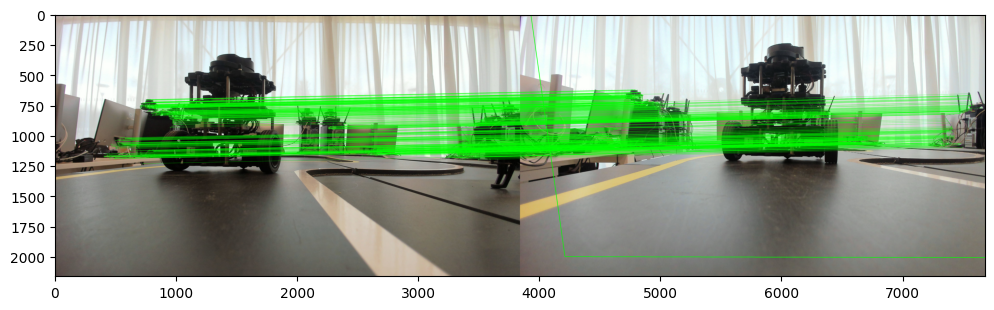

(<matplotlib.image.AxesImage at 0x7f74cc325150>, None)

In [19]:
# Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1, im2, top_k=10000)
print(mkpts_0.shape)

canvas, keypoints1, keypoints2, matches = warp_corners_and_draw_matches(
    mkpts_0, mkpts_1, im1, im2
)
print(f"Num of Matches: {np.shape(matches)}")

plt.figure(figsize=(12, 12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [ ]:
# Use out-of-the-box function for extraction + coarse-to-fine matching
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k=0)
print(mkpts_0.shape)
canvas, keypoints1, keypoints2, matches = warp_corners_and_draw_matches(
    mkpts_0, mkpts_1, im1, im2
)
print(f"Num of Matches: {np.shape(matches)}")
plt.figure(figsize=(12, 12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [20]:
pts1 = np.float32([kp.pt for kp in keypoints1])

pts2 = np.float32([kp.pt for kp in keypoints2])

pts1

array([[2296.     ,  785.8209 ],
       [1592.     ,  914.7762 ],
       [1276.     ,  970.18665],
       ...,
       [3663.     , 1217.015  ],
       [2695.     , 1148.5076 ],
       [3356.     , 1018.5448 ]], shape=(3332, 2), dtype=float32)

In [21]:
# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack(
    (R, T)
)  # Projection matrix for the second camera


print(points2_h)
# Perform triangulation to get 3D points

points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

[[1.1530000e+03 6.8104480e+02 1.0000000e+00]
 [2.3360000e+03 8.3417914e+02 1.0000000e+00]
 [2.2340000e+03 8.8555975e+02 1.0000000e+00]
 ...
 [3.7750000e+03 9.3794781e+02 1.0000000e+00]
 [2.8500000e+03 1.0548135e+03 1.0000000e+00]
 [3.5130000e+03 9.1376868e+02 1.0000000e+00]]


In [22]:
# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="XFeat Point Cloud")